# <font color='red'>Introduction
<font color='red'>In this laboratory we will get our hands dirty working with Large Language Models (e.g. GPT and BERT) to do various useful things. I you haven't already, it is highly recommended to:

+ <font color='red'>Read the [Attention is All you Need](https://arxiv.org/abs/1706.03762) paper, which is the basis for all transformer-based LLMs.
+ <font color='red'>Watch (and potentially *code along*) with this [Andrej Karpathy video](https://www.youtube.com/watch?v=kCc8FmEb1nY) which shows you how to build an autoregressive GPT model from the ground up.

# <font color='red'>Exercise 1: Warming Up
<font color='red'>In this first exercise you will train a *small* autoregressive GPT model for character generation (the one used by Karpathy in his video) to generate text in the style of Dante Aligheri. Use [this file](https://archive.org/stream/ladivinacommedia00997gut/1ddcd09.txt), which contains the entire text of Dante's Inferno (**note**: you will have to delete some introductory text at the top of the file before training). Train the model for a few epochs, monitor the loss, and generate some text at the end of training. Qualitatively evaluate the results 

Il codice sotto riportato è stato ripreso dal [github di Karpathy](https://github.com/karpathy/ng-video-lecture) e riadattato all'interno del notebook. Il testo di Dante Alighieri è nel file *Dante.txt*.

In [29]:
# Import

import torch
import torch.nn as nn
from torch.nn import functional as F

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model

Il modello qui sotto riportato è quello mostrato da Karpathy nel suo video. Non ci sono differenze.

In [2]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

### Experiment

Si noti che questa parte del notebook è stata svolta sempre seguendo il video di Karpathy e che quindi ci saranno molte somiglianze con esso.

In [3]:
# Iperparametri (sono gli stessi scelti da Karpathy)
batch_size = 64
block_size = 256
max_iters = 3000
eval_interval = 300
learning_rate = 3e-4
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)

In [4]:
def encode(string):
    return [char_to_int[ch] for ch in string]

def decode(integers):
    return[int_to_char[i] for i in integers]

In [5]:
# Apriamo il file
with open('Dante.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Prendiamo i caratteri unici nel testo
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Associamo a ogni carattere un numero (e viceversa)
char_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_char = { i:ch for i,ch in enumerate(chars) }

In [6]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

### Training and Experiments

La funzione di training riportata di seguito è ispirata al ciclo di training di Karpathy, ma ho apportato alcune modifiche per poter monitorare meglio la loss e salvare i modelli a ogni valutazione.

In [7]:
def train_dante(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    train_losses = list()
    val_losses = list()
    for i in range(max_iters):
        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        # every once in a while evaluate the loss on train and val sets
        if (i+1) % eval_interval == 0 or (i+1) == max_iters:
            losses = estimate_loss()
            torch.save(model, f'dante-{i+1}.pth')
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"step {i+1}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    return train_losses, val_losses

In [8]:
model = GPTLanguageModel().to(device)
train_losses, val_losses = train_dante(model)

step 300: train loss 2.1541, val loss 2.1841
step 600: train loss 1.6408, val loss 1.7047
step 900: train loss 1.3372, val loss 1.5493
step 1200: train loss 1.0479, val loss 1.5421
step 1500: train loss 0.7245, val loss 1.7091
step 1800: train loss 0.4121, val loss 1.9432
step 2100: train loss 0.2225, val loss 2.2876
step 2400: train loss 0.1467, val loss 2.5798
step 2700: train loss 0.1140, val loss 2.8148
step 3000: train loss 0.1010, val loss 2.9315


Ecco il grafico del training:

In [16]:
import matplotlib.pyplot as plt
import numpy as np

#Funzione per il plot del grafico
def plot(x, datas, labels, x_label, y_label, title):
    for i in range(len(datas)):
        plt.plot(x, datas[i], label = labels[i])
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

step 300: train loss 2.1541, val loss 2.1841
step 600: train loss 1.6408, val loss 1.7047
step 900: train loss 1.3372, val loss 1.5493
step 1200: train loss 1.0479, val loss 1.5421
step 1500: train loss 0.7245, val loss 1.7091
step 1800: train loss 0.4121, val loss 1.9432
step 2100: train loss 0.2225, val loss 2.2876
step 2400: train loss 0.1467, val loss 2.5798
step 2700: train loss 0.1140, val loss 2.8148
step 3000: train loss 0.1010, val loss 2.9315


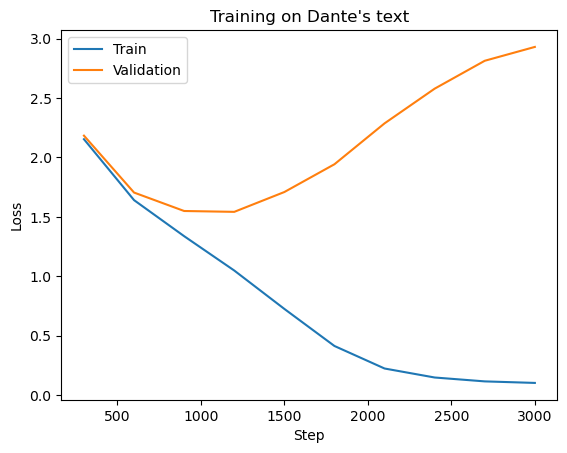

In [25]:
#Plot

x = (np.arange(len(train_losses))+1)*eval_interval

plot(
    x,
    (train_losses, val_losses),
    ('Train', 'Validation'),
    'Step',
    'Loss',
    'Training on Dante\'s text'
)

for i in range(len(x)):
    print(f"step {x[i]}: train loss {train_losses[i]:.4f}, val loss {val_losses[i]:.4f}")

Osservando il plot della loss e il log del training, si nota che il modello va in overfitting dopo 1200 iterazioni.
Di seguito si caricano il modello migliore (1200 iterazioni) e il modello più overfittato (3000 iterazioni) per fare un confronto diretto sulla generazione del testo.

In [18]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)

In [19]:
model_3000 = torch.load('dante-3000.pth')
print(''.join(decode(model.generate(context, max_new_tokens=500)[0].tolist())))


  quando Francescando spia non di lor vastro>>.

Poi cominciasce dorte dal monde manto,
  <<S'ei or de` la vita tutta morta!
  Verolte tenese ch'un poco unzo
  la test'a dir priva 'l sabbion d'inferse,

dal cinque che disperanza non e` daggire,
  li Falchi suo che l'abbianco non s'anni.

Gia` eravam la lunga conda gentero
  che si` crucciato suo l'acqua comero
  che 'l faera a le prime piu` percosso cse.

Elle rilor de la tua proda ad Atte;
  per che, se sono ricorto` quell'anima,
  tu non piego


In [20]:
model_1200 = torch.load('dante-1200.pth')
print(''.join(decode(model.generate(context, max_new_tokens=500)[0].tolist())))


ae di Polor danno, e l'altro e lor vaso;
  cadde giuso in su la ripa debia,
  e disse a Nesso: <<Or sier Bruno

lo tuo nome tornasse e rinasciati,
  a Minos a cor sie vissi  potea lascia,
  anda veder lo sentiro piu` piano,

quando incontanento a la li altri appassi,
  che 'ntrammo l'un rombe e l'armane;
  per che 'l fosso si riparea la faccia,

non che di pina, sua si saetta persa,
  mo tutto le folto infino e la chiasche,
  poi ser tra 'mpie in torna si` fresta,
  ch'alcun remar di terra a pro


### Summary

Osservando i due testi si nota come nessuno dei due sia in grado di riprodurre un testo con un vero e proprio significato. Evidentemente un modello generativo che predice in base ai caratteri non è abbastanza potente per un task simile.

# <font color='red'>Exercise 2: Working with Real LLMs

<font color='red'>Our toy GPT can only take us so far. In this exercise we will see how to use the [Hugging Face](https://huggingface.co/) model and dataset ecosystem to access a *huge* variety of pre-trained transformer models.

## <font color='red'>Exercise 2.1: Installation and text tokenization

<font color='red'>First things first, we need to install the [Hugging Face transformer library](https://huggingface.co/docs/transformers/index):

    conda install -c huggingface -c conda-forge transformers
    
<font color='red'>The key classes that you will work with are `GPT2Tokenizer` to encode text into sub-word tokens, and the `GPT2LMHeadModel`. **Note** the `LMHead` part of the class name -- this is the version of the GPT2 architecture that has the text prediction heads attached to the final hidden layer representations (i.e. what we need to **generate** text). 

<font color='red'>Instantiate the `GPT2Tokenizer` and experiment with encoding text into integer tokens. Compare the length of input with the encoded sequence length.

<font color='red'>**Tip**: Pass the `return_tensors='pt'` argument to the togenizer to get Pytorch tensors as output (instead of lists).

In [36]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [37]:
print(tokenizer("How are you?", return_tensors='pt')['input_ids'])
print(tokenizer("All is well, thank you!", return_tensors='pt')['input_ids'])
print(tokenizer("Hello world.", return_tensors='pt')['input_ids'])

tensor([[2437,  389,  345,   30]])
tensor([[3237,  318,  880,   11, 5875,  345,    0]])
tensor([[15496,   995,    13]])


Come si può notare, il modello sopra riportato crea un token diverso per ogni parola e simbolo di punteggiatura all'interno della frase. I token cambiano a seconda dell'utilizzo di lettere maiuscole o minuscole:

In [38]:
print(tokenizer("Hello world", return_tensors='pt')['input_ids'])
print(tokenizer("Hello World", return_tensors='pt')['input_ids'])

tensor([[15496,   995]])
tensor([[15496,  2159]])


 I segni di punteggiatura sono dei token a parte, infatti se si prende la stessa frase con e senza punteggiatura, si nota che vengono gli stessi token a parte per i segni di punteggiatura:

In [39]:
print(tokenizer("Hello world", return_tensors='pt')['input_ids'])
print(tokenizer("Hello world!", return_tensors='pt')['input_ids'])
print(tokenizer("Hello world.", return_tensors='pt')['input_ids'])
print(tokenizer("Hello world?", return_tensors='pt')['input_ids'])
print(tokenizer("Hello! world!", return_tensors='pt')['input_ids'])

tensor([[15496,   995]])
tensor([[15496,   995,     0]])
tensor([[15496,   995,    13]])
tensor([[15496,   995,    30]])
tensor([[15496,     0,   995,     0]])


Inoltre se si combinano segni di punteggiatura diversi, si otterrà un token diverso:

In [40]:
print(tokenizer("Hello world!", return_tensors='pt')['input_ids'])
print(tokenizer("Hello world?", return_tensors='pt')['input_ids'])
print(tokenizer("Hello world?!", return_tensors='pt')['input_ids'])
print(tokenizer("Hello world!?", return_tensors='pt')['input_ids'])

tensor([[15496,   995,     0]])
tensor([[15496,   995,    30]])
tensor([[15496,   995, 12248]])
tensor([[15496,   995, 22857]])


Infine, il tokenizer è settato sulla lingua inglese. Infatti, se si prova a scrivere una frase in un'altra lingua il numero di token non corrisponde al numero di parole:

In [41]:
print(tokenizer("Ciao, come stai?", return_tensors='pt')['input_ids'])

tensor([[   34, 13481,    11,  1282,   336,  1872,    30]])


## <font color='red'>Exercise 2.2: Generating Text

<font color='red'>There are a lot of ways we can, given a *prompt* in input, sample text from a GPT2 model. Instantiate a pre-trained `GPT2LMHeadModel` and use the [`generate()`](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to generate text from a prompt.

<font color='red'>**Note**: The default inference mode for GPT2 is *greedy* which might not results in satisfying generated text. Look at the `do_sample` and `temperature` parameters.

In [51]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GenerationConfig

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
configuration = GenerationConfig(max_length=40, pad_token_id=4300)

inputs = tokenizer("Hello, how are you?", return_tensors="pt")
outputs = model.generate(**inputs, generation_config=configuration)
tokenizer.batch_decode(outputs)

["Hello, how are you?\n\nI'm a little bit of a nerd. I'm a big nerd. I'm a big nerd. I'm a big nerd. I'm a big nerd"]

In questo primo esperimento, si vede come la frase generata dal modello non abbia effettivamente senso compiuto.

Proviamo ora a giocare con i parametri:
- do_sample -> per passare da un decoding di tipo greedy a utilizzare effettivamente un sampling;
- temperature -> parametro usato per manipolare la probabilità del token successivo.

In [58]:
configuration2 = GenerationConfig(max_length=40, pad_token_id=4300, do_sample = True, temperature = 0.5)
outputs2 = model.generate(**inputs, generation_config=configuration2)
tokenizer.batch_decode(outputs2)

['Hello, how are you? I\'m just sitting here and typing this.\n\n"Hello, how are you?"\n\n"You\'re fine. I\'m doing okay."\n\n"Yeah']

In [59]:
configuration3 = GenerationConfig(max_length=40, pad_token_id=4300, do_sample = True, temperature = 0.3)
outputs3 = model.generate(**inputs, generation_config=configuration3)
tokenizer.batch_decode(outputs3)

["Hello, how are you?\n\nI'm very happy.\n\nI'm very happy.\n\nI'm very happy.\n\nI'm very happy.\n\nI'm very happy"]

In tutti i casi, si vede come il modello non crei effettivamente una frase di senso compiuto e nei casi in cui prevale il decoding di tipo greedy ripeta le stesse parole all'infinito.

# <font color='red'>Exercise 3: Reusing Pre-trained LLMs (choose one)

<font color='red'>Choose **one** of the following exercises (well, *at least* one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistillBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

+ <font color='red'>Since GPT2 is a *autoregressive* model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select *one* to use).

+ <font color='red'>BERT models (including DistillBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

+ <font color='red'><font color='red'>The first *two* exercises below can probably be done *without* any fine-tuning -- that is, just training a shallow MLP to classify or represent with the appropriate loss function.


# <font color='red'>Exercise 3.2: Training a Question Answering Model (harder)

<font color='red'>Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a *moderately* sized one and train a model to answer contextualized multiple-choice questions. You *might* be able to avoid fine-tuning by training a simple model to *rank* the multiple choices (see margin ranking loss in Pytorch).

Per svolgere questo esercizio si è studiato e approfondito il tutorial presente sul sito di Hugging Face

### Dataset

Per prima cosa, scarichiamo il dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("cosmos_qa", "regular")

Found cached dataset cosmos_qa (C:/Users/Sofy/.cache/huggingface/datasets/cosmos_qa/regular/0.1.0/3e18538cbfdb2c04189b16642715f0f6da3e97ed5df0aadcec3641245b2cf157)


  0%|          | 0/3 [00:00<?, ?it/s]

E vediamo come è strutturato:

In [3]:
dataset['train'][0]

{'id': '3Q9SPIIRWJKVQ8244310E8TUS6YWAC##34V1S5K3GTZMDUBNBIGY93FLDOB690##A1S1K7134S2VUC##Blog_1044056##q1_a1##3XU9MCX6VQQG7YPLCSAFDPQNH4GR20',
 'context': "Good Old War and person L : I saw both of these bands Wednesday night , and they both blew me away . seriously . Good Old War is acoustic and makes me smile . I really can not help but be happy when I listen to them ; I think it 's the fact that they seemed so happy themselves when they played .",
 'question': 'In the future , will this person go to see other bands play ?',
 'answer0': 'None of the above choices .',
 'answer1': 'This person likes music and likes to see the show , they will see other bands play .',
 'answer2': 'This person only likes Good Old War and Person L , no other bands .',
 'answer3': 'Other Bands is not on tour and this person can not see them .',
 'label': 1}

Come si può osservare, ogni entry del dataset, presenta:
- un **id**;
- un **contesto** per la domanda;
- la **domanda** a cui si dovrà rispondere;
- quattro possibili **risposte**;
- la **label** con indicato la risposta corretta.

Per poter fare il fine-tuning di un modello già esistente è necessario svolgere prima una fase di preprocessing del dataset.

### Fase di preprocessing
In questa fase di preprocessing, si vanno a creare i token del contesto unito alla domanda e alle quattro risposte possibili.

In [4]:
from transformers import DistilBertTokenizer

ending_names = ["answer0", "answer1", "answer2", "answer3"]

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    first_sentences = [[context] * 4 for context in examples["context"]]
    question_headers = examples["question"]
    second_sentences = [
        [f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)
    ]

    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    return {k: [v[i : i + 4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}

Per eseguire il preprocessing sull'intero dataset, si una la funzione map:

In [5]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at C:\Users\Sofy\.cache\huggingface\datasets\cosmos_qa\regular\0.1.0\3e18538cbfdb2c04189b16642715f0f6da3e97ed5df0aadcec3641245b2cf157\cache-4fe95802ad28fd49.arrow
Loading cached processed dataset at C:\Users\Sofy\.cache\huggingface\datasets\cosmos_qa\regular\0.1.0\3e18538cbfdb2c04189b16642715f0f6da3e97ed5df0aadcec3641245b2cf157\cache-9debe1a1399a85e8.arrow
Loading cached processed dataset at C:\Users\Sofy\.cache\huggingface\datasets\cosmos_qa\regular\0.1.0\3e18538cbfdb2c04189b16642715f0f6da3e97ed5df0aadcec3641245b2cf157\cache-e6f2aeaf7bcecc5a.arrow


In [6]:
tokenized_dataset['train']

Dataset({
    features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'label', 'input_ids', 'attention_mask'],
    num_rows: 25262
})

Come si può vedere, il dataset risultante ha gli stessi campi del precedente dataset ma ha adesso anche due campi aggiuntivi:
- il campo **inputs_ids** che contiene i token di context + question + answer;
- il campo **attention_mask** che serve a indicare su quali token di *input_ids* porre l'attenzione.


Per generare i batch per il fine tuning, si deve utilizzare un **Data Collator**: cioè uno strumento che inserisce il padding a ogni elemento del dataset per fare in modo che tutti gli elementi del batch abbiano la stessa grandezza.

In [7]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch


@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features] if label_name in features[0].keys() else None
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        if labels is not None:
            batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

### Accuracy Function

Come metrica, ho deciso di calcolare l'accuracy.

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np

# Funzione per calcolare l'accuracy
def accuracy(eval_pred):
    y_pred, y_true = eval_pred
    y_pred = np.argmax(y_pred, axis=1)
    return {'accuracy': accuracy_score(y_true, y_pred)}

### Fine tuning

Usiamo adesso i Trainer di pytorch per fare il fine-tuning del modello.

In [9]:
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer

model = AutoModelForMultipleChoice.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

In [11]:
training_args = TrainingArguments(
    output_dir="my_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
    compute_metrics=accuracy,
)

In [12]:
trainer.train()

C:\Users\Sofy\miniconda3\envs\DLA\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.056300,1.005294,0.596315
2,0.606500,1.358598,0.561809
3,0.218000,2.640128,0.558794


TrainOutput(global_step=9474, training_loss=0.6601521300947412, metrics={'train_runtime': 26724.5877, 'train_samples_per_second': 2.836, 'train_steps_per_second': 0.355, 'total_flos': 2.170273020618485e+16, 'train_loss': 0.6601521300947412, 'epoch': 3.0})

### Testing

Il dataset scelto non presenta delle label valide all'interno del test_set. Di conseguenza, non possiamo calcolare l'accuracy sul test_set.

Nota: ho guardato diversi dataset prima di scegliere questo e nessuno di loro aveva le label per tutti e tre i set (train, validation e test).

In [10]:
model = AutoModelForMultipleChoice.from_pretrained('my_model/checkpoint-9474')

La funzione predict() del trainer di hugging face funziona anche senza che vengano passate le label. Ho quindi eliminato le label dal test_set prima di continuare:

In [12]:
test_data = tokenized_dataset['test']
test_data = test_data.remove_columns("label")
test_data

Dataset({
    features: ['id', 'context', 'question', 'answer0', 'answer1', 'answer2', 'answer3', 'input_ids', 'attention_mask'],
    num_rows: 6963
})

In [13]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
)

In [15]:
model.eval()
test_result = trainer.predict(test_data)

In [16]:
test_result

PredictionOutput(predictions=array([[-11.18111  ,  -6.029766 , -12.528319 , -12.3311825],
       [ -8.765934 ,  -7.91253  ,   8.332372 ,   2.9878469],
       [ -0.3738349,   3.801273 ,  11.359877 ,   3.3177714],
       ...,
       [ -6.252652 ,  -6.411227 ,  -7.7708454,   5.3823843],
       [-12.507664 , -11.57149  ,  -6.6277285,  11.902547 ],
       [  1.8697493,  -4.919432 ,   6.771773 ,  12.320783 ]],
      dtype=float32), label_ids=None, metrics={'test_runtime': 78.7702, 'test_samples_per_second': 88.396, 'test_steps_per_second': 11.057})

In [26]:
predictions = test_result.predictions.argmax(axis=1)

Abbiamo ottenuto così la risposta predetta dal modello per ogni domanda nel test_set.

Se ad esempio osserviamo la prima:

In [25]:
print(f"context: {test_data[0]['context']}")
print(f"question: {test_data[0]['question']}")
print(f"answer0: {test_data[0]['answer0']}")
print(f"answer1: {test_data[0]['answer1']}")
print(f"answer2: {test_data[0]['answer2']}")
print(f"answer3: {test_data[0]['answer3']}")

context: HGH and steroid use is rampant in track , and , just like in most American professional sports , any incredible individual achievement is questioned immediately , which is a sad state of affairs . The fact that we , as a human population have to assume that someone is using steroids because of an outstanding feat is horrible . What about the people who actually train their hearts out to achieve the same success that the users are trying to achieve ? It is n't fair to the men and women that dedicate their lives to achieving glory the right way , hard work and determination .
question: Why is HGH and steroid use rampant in track ?
answer0: Because we have to assume that someone is using steroids because of an outstanding feat .
answer1: None of the above choices .
answer2: Because any incredible individual achievement is questioned immediately .
answer3: Because it 's an American professional sport .


Abbiamo che la risposta predetta è:

In [27]:
print(f"predicted answer: answer number {predictions[0]}")

predicted answer: answer number 1


Cioé:

In [28]:
test_data[0]['answer1']

'None of the above choices .'